In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
data = pd.read_csv("crx.csv", encoding="utf-8")
df = data.replace('?', np.nan)
df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.5,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,-


### Feature included
A1: b, a. A2: continuous. A3: continuous. A4: u, y, l, t. A5: g, p, gg. A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff. A7: v, h, bb, j, n, z, dd, ff, o. A8: continuous. A9: t, f. A10: t, f. A11: continuous. A12: t, f. A13: g, p, s. A14: continuous. A15: continuous. A16: +,-

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=522)

In [4]:
#find the columns which have NA values 
train_df.isna().sum(axis= 0)

A1      8
A2     10
A3      0
A4      3
A5      3
A6      6
A7      6
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14     8
A15     0
A16     0
dtype: int64

A1, A2, A4, A5, A6, A7, A14 all have some missing values. A2 and A14 are numerical, otherwise, they are categorical. In this case, I will fill the na values with most frequent value for categorical columns, and fill na with median value for numerical columns.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 146 to 288
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      544 non-null    object 
 1   A2      542 non-null    object 
 2   A3      552 non-null    float64
 3   A4      549 non-null    object 
 4   A5      549 non-null    object 
 5   A6      546 non-null    object 
 6   A7      546 non-null    object 
 7   A8      552 non-null    float64
 8   A9      552 non-null    object 
 9   A10     552 non-null    object 
 10  A11     552 non-null    int64  
 11  A12     552 non-null    object 
 12  A13     552 non-null    object 
 13  A14     544 non-null    object 
 14  A15     552 non-null    int64  
 15  A16     552 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 73.3+ KB


The A2 and A14 should be numerical, but it is not in the dataframe, hence, we have to convert the data type

In [6]:
train_df['A2'] = pd.to_numeric(train_df['A2'])
train_df['A14'] = pd.to_numeric(train_df['A14'], downcast='integer')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552 entries, 146 to 288
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      544 non-null    object 
 1   A2      542 non-null    float64
 2   A3      552 non-null    float64
 3   A4      549 non-null    object 
 4   A5      549 non-null    object 
 5   A6      546 non-null    object 
 6   A7      546 non-null    object 
 7   A8      552 non-null    float64
 8   A9      552 non-null    object 
 9   A10     552 non-null    object 
 10  A11     552 non-null    int64  
 11  A12     552 non-null    object 
 12  A13     552 non-null    object 
 13  A14     544 non-null    float64
 14  A15     552 non-null    int64  
 15  A16     552 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 73.3+ KB


<AxesSubplot:title={'center':'Feature target value counts'}, ylabel='Value splits'>

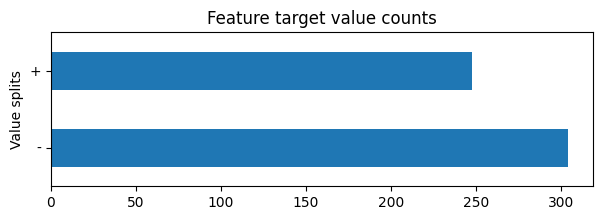

In [7]:
train_df['A16'].value_counts().plot(kind='barh', figsize=(7,2), title = "Feature target value counts", xlabel = "Value splits")

Good news, our target data is balanced

### Data preprocessing

In [8]:
#split the data into X_train and y_train
X_train, y_train = train_df.drop(columns=['A16']), train_df['A16']
X_test, y_test = test_df.drop(columns=['A16']), test_df['A16']

In [9]:
#fill missing value with most frequent value of that column for categorical; mean value for numerical 
cat_imputer = SimpleImputer(strategy='most_frequent', fill_value=np.nan)
num_imputer = SimpleImputer(strategy='mean', fill_value= np.nan)

In [10]:
#seperate columns by data type
numeric_features_nomi = [ 'A3', 'A8', 'A11', 'A15']
numeric_features_miss = ['A2', 'A14']
binary_feature_miss = ['A1']
binary_feature_nomi = ['A9', 'A10', 'A12']
categorical_features_nomi = ['A13']
categorical_features_miss = ['A4', 'A5', 'A6', 'A7']

In [11]:
num_transformer = make_pipeline(num_imputer, StandardScaler())
cat_transformer_bi = make_pipeline(cat_imputer, OneHotEncoder(drop = 'if_binary', sparse=False, handle_unknown= 'ignore'))
cat_transformer_nonbi = make_pipeline(cat_imputer, OneHotEncoder(sparse=False, handle_unknown= 'ignore'))
preprocessor = make_column_transformer(
    (num_transformer, numeric_features_miss),
    (StandardScaler(), numeric_features_nomi),
    (cat_transformer_bi, binary_feature_miss),
    (OneHotEncoder(drop = 'if_binary', sparse=False, handle_unknown= 'ignore'), binary_feature_nomi),
    (cat_transformer_nonbi, categorical_features_miss),
    (OneHotEncoder(sparse=False, handle_unknown= 'ignore'), categorical_features_nomi)
)

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=nan)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['A2', 'A14']),
                                ('standardscaler', StandardScaler(),
                                 ['A3', 'A8', 'A11', 'A15']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=nan,
                                                                strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEn...
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['A9', 'A10', 'A12']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=nan,
                                                                strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['A4', 'A5', 'A6', 'A7']),
                                ('onehotencoder-2',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['A13'])])

In [12]:
cross_val_results= {}
#dummy classifier as a baseline, default R^2 score
dum_pipe = make_pipeline(preprocessor, DummyClassifier())
cross_val_results['dummy'] = pd.DataFrame(cross_validate(dum_pipe, X_train, y_train, return_train_score=True)).agg(['mean', 'std']).round(3).T

cross_val_results['dummy']

,mean,std
fit_time,0.007,0.001
score_time,0.003,0.000
test_score,0.551,0.004
train_score,0.551,0.001


In [13]:
#logistic regression score, default R^2 score
logreg = make_pipeline(preprocessor, LogisticRegression(random_state=522))
cross_val_results['logreg'] = pd.DataFrame(cross_validate(logreg, X_train, y_train, return_train_score=True)).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

,mean,std
fit_time,0.026,0.013
score_time,0.008,0.007
test_score,0.879,0.012
train_score,0.883,0.006


In [14]:
#SVC model
svc_pipe = make_pipeline(preprocessor, SVC(random_state=522))
cross_val_results['svc'] = pd.DataFrame(cross_validate(svc_pipe, X_train, y_train, return_train_score=True)).agg(['mean', 'std']).round(3).T

cross_val_results['svc']

,mean,std
fit_time,0.013,0.004
score_time,0.007,0.002
test_score,0.857,0.024
train_score,0.897,0.005


In [15]:
pd.concat(cross_val_results, axis=1)

dummy        logreg           svc       
              mean    std   mean    std   mean    std
fit_time     0.007  0.001  0.026  0.013  0.013  0.004
score_time   0.003  0.000  0.008  0.007  0.007  0.002
test_score   0.551  0.004  0.879  0.012  0.857  0.024
train_score  0.551  0.001  0.883  0.006  0.897  0.005

### SVC and Logistic regression are similiar. Let's do a randon search for opimization for both of them

#### SVC randomized search

In [16]:
param_dist = {
"svc__class_weight": [None, "balanced"],
"svc__gamma": 10.0 ** np.arange(-2, 3),
"svc__C": 10.0 ** np.arange(-2, 3)
}

random_search = RandomizedSearchCV(svc_pipe, param_distributions=param_dist, return_train_score=True, n_jobs = -1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(fill_value=nan)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['A2',
                                                                                'A14']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['A3',
                                                                                'A8',
                                                                                'A11',
                                                                                'A15']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(f...
                                                                                                              sparse=False))]),
                                                                               ['A4',
                                                                                'A5',
                                                                                'A6',
                                                                                'A7']),
                                                                              ('onehotencoder-2',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['A13'])])),
                                             ('svc', SVC(random_state=522))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                                        'svc__class_weight': [None, 'balanced'],
                                        'svc__gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                   return_train_score=True)

In [17]:
print(random_search.best_params_)

{'svc__gamma': 0.1, 'svc__class_weight': 'balanced', 'svc__C': 10.0}


In [18]:
best_svc = random_search.best_estimator_
cross_val_results['best_svc'] = pd.DataFrame(cross_validate(best_svc, X_train, y_train, return_train_score=True)).agg(['mean', 'std']).round(3).T

cross_val_results['best_svc']

,mean,std
fit_time,0.010,0.001
score_time,0.005,0.000
test_score,0.870,0.013
train_score,0.971,0.005


#### Logistic Regression Randomized Search

In [19]:
param_dist2 = {
"logisticregression__C": np.logspace(-3,3,7),
"logisticregression__penalty" : ['l1','l2']
}

random_search_log = GridSearchCV(logreg, param_dist2, return_train_score=True, n_jobs = -1)
random_search_log.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value=nan)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['A2',
                                                                          'A14']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['A3',
                                                                          'A8',
                                                                          'A11',
                                                                          'A15']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_va...
                                                                                                        sparse=False))]),
                                                                         ['A4',
                                                                          'A5',
                                                                          'A6',
                                                                          'A7']),
                                                                        ('onehotencoder-2',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['A13'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=522))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'logisticregression__penalty': ['l1', 'l2']},
             return_train_score=True)

In [20]:
print(random_search_log.best_params_)

{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}


In [21]:
best_logreg = random_search_log.best_estimator_
cross_val_results['best_logreg'] = pd.DataFrame(cross_validate(best_logreg, X_train, y_train, return_train_score=True)).agg(['mean', 'std']).round(3).T

cross_val_results['best_logreg']

,mean,std
fit_time,0.016,0.003
score_time,0.003,0.000
test_score,0.879,0.012
train_score,0.883,0.006


In [22]:
pd.concat(cross_val_results, axis=1)

dummy        logreg           svc        best_svc         \
              mean    std   mean    std   mean    std     mean    std   
fit_time     0.007  0.001  0.026  0.013  0.013  0.004    0.010  0.001   
score_time   0.003  0.000  0.008  0.007  0.007  0.002    0.005  0.000   
test_score   0.551  0.004  0.879  0.012  0.857  0.024    0.870  0.013   
train_score  0.551  0.001  0.883  0.006  0.897  0.005    0.971  0.005   

            best_logreg         
                   mean    std  
fit_time          0.016  0.003  
score_time        0.003  0.000  
test_score        0.879  0.012  
train_score       0.883  0.006

The best model is logistic regression with default hyperparameters

In [23]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=nan)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['A2', 'A14']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['A3', 'A8', 'A11', 'A15']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='most_...
                                                  ['A9', 'A10', 'A12']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=nan,
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['A4', 'A5', 'A6', 'A7']),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['A13'])])),
                ('logisticregression', LogisticRegression(random_state=522))])

In [24]:
logreg.score(X_test, y_test)

0.855072463768116

In [25]:
final_table = pd.concat(cross_val_results, axis=1)
final_table

dummy        logreg           svc        best_svc         \
              mean    std   mean    std   mean    std     mean    std   
fit_time     0.007  0.001  0.026  0.013  0.013  0.004    0.010  0.001   
score_time   0.003  0.000  0.008  0.007  0.007  0.002    0.005  0.000   
test_score   0.551  0.004  0.879  0.012  0.857  0.024    0.870  0.013   
train_score  0.551  0.001  0.883  0.006  0.897  0.005    0.971  0.005   

            best_logreg         
                   mean    std  
fit_time          0.016  0.003  
score_time        0.003  0.000  
test_score        0.879  0.012  
train_score       0.883  0.006

In [27]:
#final_table.to_csv('score_table.csv', sep=',', encoding='utf-8')